In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

In [2]:
# Load the data
data_down = np.genfromtxt('maze_data_down.csv', delimiter=',')
data_right = np.genfromtxt('maze_data_right.csv', delimiter=',')

data_down = data_down[1:, 1:]
data_right = data_right[1:, 1:]

In [3]:
def draw_maze(data_down, data_right, color, linewidth, sol=None):
    m, n = data_down.shape

    plt.axis('off')
    plt.gca().set_prop_cycle(color=[color], linewidth=[linewidth])
    plt.gca().set_aspect('equal')
    plt.gca().set_xlim(-1, m)
    plt.gca().set_ylim(-1, n)
    plt.gca().invert_yaxis()

    # Plot outer lines
    plt.plot(-0.5 + np.arange(1, n + 1), -0.5 + np.zeros(n))
    plt.plot(-0.5 + np.arange(0, n), -0.5 + m * np.ones(n))
    plt.plot(-0.5 + np.zeros(m), -0.5 + np.arange(1, m + 1))
    plt.plot(-0.5 + n * np.ones(m), -0.5 + np.arange(0, m))

    # Plot vertical lines
    for i in range(m):
        for j in range(n - 1):
            if data_right[i, j] == 0:
                plt.plot([-0.5 + j + 1, -0.5 + j + 1], [-0.5 + i, -0.5 + i + 1])

    # Plot horizontal lines
    for j in range(n):
        for i in range(m - 1):
            if data_down[i, j] == 0:
                plt.plot([-0.5 + j, -0.5 + j + 1], [-0.5 + i + 1, -0.5 + i + 1])

    # Plot the solution, if provided
    if sol is not None:
        plt.imshow(sol, cmap='plasma')

    plt.show()

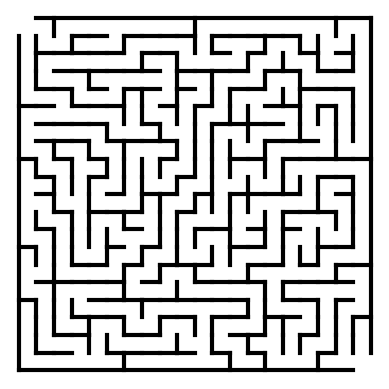

In [4]:
# Draw the maze
draw_maze(data_down, data_right, 'k', 3)

In [5]:
def make_adjacency_matrix(data_down, data_right):
  m, n = data_down.shape

  rows = []
  cols = []

  for i in range(m):
    for j in range(n - 1):
      if data_right[i, j] == 1:
        ind = j * m + i
        rows.append(ind)
        cols.append(ind + m)
        rows.append(ind + m)
        cols.append(ind)

  for j in range(n):
    for i in range(m - 1):
      if data_down[i, j] == 1:
        ind = j * m + i
        rows.append(ind)
        cols.append(ind + 1)
        rows.append(ind + 1)
        cols.append(ind)

  data = np.ones(len(rows))
  A = sparse.csr_array((data, (rows, cols)))
  return A

In [6]:
# Generate adjacency matrix
m, n = data_down.shape
N = m * n
A = make_adjacency_matrix(data_down, data_right)

In [7]:
# Convert adjacency matrix to stochastic matrix
row_sums = np.sum(A, axis=1)
R = sparse.spdiags(1 / row_sums, 0, N, N)
P = R @ A

In [8]:
# Setup linear system for the committor problem
exit_A = 0
exit_B = N - 1

x = np.zeros((N, 1))
x[exit_B] = 1

I = sparse.eye(N)
L = P - I
b = -L @ x

ind_exits = np.union1d([exit_A], [exit_B])
ind_unknown = np.setdiff1d(np.arange(0, N), ind_exits)

In [9]:
# Make the system symmetric positive definite
r_sqrt = np.sqrt(row_sums)
D = sparse.spdiags(r_sqrt, 0, N, N)
D_inv = sparse.spdiags(1 / r_sqrt, 0, N, N)

L_symm = D @ L @ D_inv
b_symm = D @ b

In [10]:
# Algorithm 5.2
def conj_grad(A, b, x0):
  x = x0
  r = A @ x - b
  p = -r

  res_list = []
  while True:
    res_list.append(np.linalg.norm(r))
    if res_list[-1] < 1e-12:
      break

    alpha = (r.T @ r) / (p.T @ A @ p)
    x_new = x + alpha * p
    r_new = r + alpha * (A @ p)
    beta = (r_new.T @ r_new) / (r.T @ r)
    p_new = -r_new + beta * p

    x = x_new
    r = r_new
    p = p_new

  return x, res_list

In [11]:
y, res = conj_grad(-L_symm[1:-1, 1:-1], -b_symm[ind_unknown], D.toarray()[1:-1, 1:-1] @ x[ind_unknown])
probs = x
probs[ind_unknown] = D_inv.toarray()[1:-1, 1:-1] @ y
probs = probs.reshape(20, 20).T

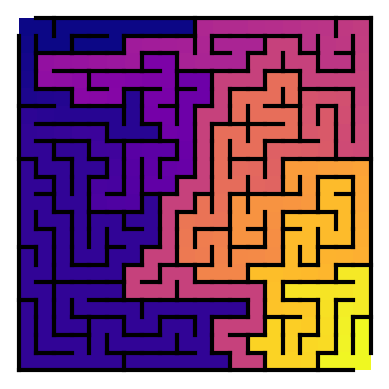

In [12]:
draw_maze(data_down, data_right, 'k', 3, probs)

In [13]:
def ichol(A):
    n = A.shape[0]

    for k in range(n):
        A[k, k] = np.sqrt(A[k, k])

        for i in range(k + 1, n):
            if A[i, k] != 0:
                A[i, k] /= A[k, k]

        for j in range(k + 1, n):
            for i in range(j, n):
                if A[i, j] != 0:
                    A[i, j] -= A[i, k] * A[j, k]

    for i in range(n):
        for j in range(i + 1, n):
            A[i, j] = 0

    return A


In [14]:
ichol_fac = ichol(-L_symm.toarray())
M = ichol_fac @ ichol_fac.T

In [15]:
# Algorithm 5.3
def conj_grad_precondition(A, b, M, x0):
  x = x0
  r = A @ x - b
  y = np.linalg.solve(M, r)
  p = -y

  res_list = []
  while True:
    res_list.append(np.linalg.norm(r))
    if res_list[-1] < 1e-12:
      break

    alpha = (r.T @ y) / (p.T @ A @ p)
    x_new = x + alpha * p
    r_new = r + alpha * (A @ p)
    y_new = np.linalg.solve(M, r_new)
    beta = (r_new.T @ y_new) / (r.T @ y)
    p_new = -y_new + beta * p

    x = x_new
    r = r_new
    y = y_new
    p = p_new

  return x, res_list

In [16]:
x = np.zeros((N, 1))
x[exit_B] = 1

y, res_pre = conj_grad_precondition(-L_symm[1:-1, 1:-1], -b_symm[ind_unknown], M[1:-1, 1:-1], D.toarray()[1:-1, 1:-1] @ x[ind_unknown])

probs_pre = x
probs_pre[ind_unknown] = D_inv.toarray()[1:-1, 1:-1] @ y
probs_pre = probs_pre.reshape(20, 20).T

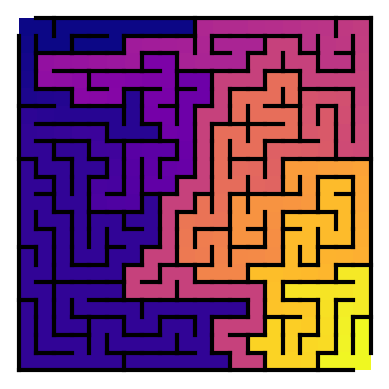

In [17]:
draw_maze(data_down, data_right, 'k', 3, probs_pre)

In [18]:
def plot_residuals(res, res_pre):
  plt.plot(res, c='r', label='Without Preconditioning')
  plt.plot(res_pre, c='b', label='With Preconditioning')
  plt.title("Comparison of CG Algorithms 5.2 and 5.3")
  plt.xlabel("iteration")
  plt.ylabel("residual (log)")
  plt.yscale("log")
  plt.legend()
  plt.show()

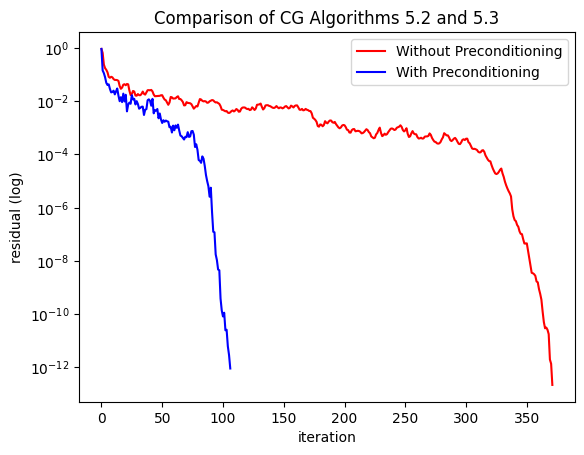

In [19]:
plot_residuals(res, res_pre)

In [20]:
# Save arrays into hw9 directory
np.savez('../hw9/hw8_data.npz', L_symm.toarray()[1:-1, 1:-1], b_symm[1:-1], y)